In [ ]:
!pip install opencv-python pandas scikit-learn torch torchvision pillow matplotlib tqdm

In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')
# Definisci il percorso
path = '/content/drive/MyDrive/ProgettoDLA'
# Spostati nella directory
os.chdir(path)
# Verifica di essere nel posto giusto
print(os.getcwd())

Mounted at /content/drive
/content/drive/MyDrive/ProgettoDLA


In [ ]:
!cp "/content/drive/MyDrive/ProgettoDLA/dataset_resized_3split_unbalanced_128.zip" "/content/dataset_resized_3split_unbalanced_128.zip"
!unzip -q "/content/dataset_resized_3split_unbalanced_128.zip" -d "/content/dataset_resized_3split_unbalanced_128"

In [ ]:
import os
import cv2
import numpy as np
import random
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch # Se ti serve dopo
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
# import pandas as pd  <-- RIMOSSO

In [ ]:
# --- CONFIGURAZIONE ---
ORIGINAL_DATASET_PATH = 'flowers'   # La tua cartella originale
PROCESSED_DIR = 'dataset_resized_3split_unbalanced_128'   # Dove salveremo le immagini pronte
IMG_SIZE = (128,128)

# Funzione per salvare le immagini su disco partendo da liste
def process_and_save(paths, labels, split_name):
    save_dir = os.path.join(PROCESSED_DIR, split_name)
    print(f"Elaborazione e salvataggio: {split_name}...")

    # Usiamo zip per iterare su percorsi ed etichette insieme
    for src_path, label in tqdm(zip(paths, labels), total=len(paths)):

        # Crea cartella classe se non esiste
        class_dir = os.path.join(save_dir, label)
        os.makedirs(class_dir, exist_ok=True)

        # Carica immagine
        img = cv2.imread(src_path)
        if img is None:
            continue

        # Resize
        img = cv2.resize(img, IMG_SIZE)

        # Costruiamo il nome file di destinazione
        filename = os.path.basename(src_path)
        dst_path = os.path.join(class_dir, filename)

        # Salva immagine ridimensionata
        cv2.imwrite(dst_path, img)

# --- 1. CONTROLLO ESISTENZA DATASET ---
if os.path.exists(PROCESSED_DIR):
    print(f"La cartella '{PROCESSED_DIR}' esiste già.")
    print("Salto la creazione e il resize delle immagini.")

else:
    print(f"La cartella '{PROCESSED_DIR}' non esiste. Inizio creazione dataset...")
    if not os.path.exists(ORIGINAL_DATASET_PATH):
        os.makedirs(ORIGINAL_DATASET_PATH, exist_ok=True)
        raise FileNotFoundError(f"Inserisci le immagini in: {ORIGINAL_DATASET_PATH}")

    # --- A. SCANSIONE E RAGGRUPPAMENTO PER CLASSE ---
    # Usiamo un dizionario per raggruppare: {'rosa': [path1, path2], 'margherita': [...]}
    data_by_class = {}

    valid_extensions = ('.jpg', '.jpeg', '.png')

    for label in os.listdir(ORIGINAL_DATASET_PATH):
        class_dir = os.path.join(ORIGINAL_DATASET_PATH, label)
        if os.path.isdir(class_dir):
            data_by_class[label] = []
            for filename in os.listdir(class_dir):
                if filename.lower().endswith(valid_extensions):
                    data_by_class[label].append(os.path.join(class_dir, filename))

    # Controllo se vuoto
    if not data_by_class:
        raise ValueError("Non ho trovato immagini o sottocartelle!")

    # --- B. BILANCIAMENTO ---
    # Troviamo il numero minimo di immagini tra tutte le classi
    # min_samples = min(len(paths) for paths in data_by_class.values())
    # print(f"Bilanciamento classi a {min_samples} immagini ciascuna.")

    all_paths = []
    all_labels = []

    for label, paths in data_by_class.items():
        # Mescoliamo le immagini per prenderne un campione casuale
        random.shuffle(paths)

        # Prendiamo solo le prime 'min_samples' immagini (Slicing)
        selected_paths = paths#[:min_samples]

        all_paths.extend(selected_paths)
        all_labels.extend([label] * len(selected_paths))

    # --- C. SPLIT ---
    # Usiamo train_test_split direttamente sulle liste
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        all_paths, all_labels,
        test_size=0.30,
        stratify=all_labels,
        random_state=42
    )

    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels,
        test_size=0.50,
        stratify=temp_labels,
        random_state=42
    )

    # --- D. SALVATAGGIO ---
    process_and_save(train_paths, train_labels, 'train')
    process_and_save(val_paths, val_labels, 'val')
    process_and_save(test_paths, test_labels, 'test') # Salviamo anche il test set

    print("Creazione dataset completata con split Train/Val/Test.")

# --- 2. CARICAMENTO DAL DATASET RIDIMENSIONATO ---
# (Questa parte rimane identica perché legge dalle cartelle fisiche create sopra)
print("\nCaricamento dati in memoria da disco...")

def load_from_processed_dir(split_name, class_map):
    images = []
    labels = []
    base_path = os.path.join(PROCESSED_DIR, split_name)

    for class_name, class_idx in class_map.items():
        class_path = os.path.join(base_path, class_name)
        if not os.path.exists(class_path):
            continue

        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path)
            if img is None: continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img / 255.0

            images.append(img)
            labels.append(class_idx)

    return np.array(images, dtype=np.float32), np.array(labels)

# Genera mappa classi
train_dir = os.path.join(PROCESSED_DIR, 'train')
if not os.path.exists(train_dir):
     raise FileNotFoundError(f"Errore: {train_dir} non trovato.")

classes = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

print(f"Classi trovate: {class_to_idx}")

X_train, y_train = load_from_processed_dir('train', class_to_idx)
X_val, y_val = load_from_processed_dir('val', class_to_idx)
X_test, y_test = load_from_processed_dir('test', class_to_idx)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

La cartella 'dataset_resized_3split_unbalanced_128' esiste già.
Salto la creazione e il resize delle immagini.

Caricamento dati in memoria da disco...
Classi trovate: {'astilbe': 0, 'bellflower': 1, 'black_eyed_susan': 2, 'calendula': 3, 'california_poppy': 4, 'carnation': 5, 'common_daisy': 6, 'coreopsis': 7, 'daffodil': 8, 'dandelion': 9, 'iris': 10, 'lavender': 11, 'lotus': 12, 'magnolia': 13, 'orchid': 14, 'rose': 15, 'sunflower': 16, 'tulip': 17, 'water_lily': 18}
X_train shape: (12060, 128, 128, 3)
y_train shape: (12060,)


=== STATISTICHE DATASET TRAIN ===
Numero totale immagini: 12060
Dimensione immagine: 128x128 con 3 canali
Valore minimo pixel: 0.00
Valore massimo pixel: 1.00

--- Conteggio Classi Train ---
Classe 0 (astilbe): 516 immagini
Classe 1 (bellflower): 611 immagini
Classe 2 (black_eyed_susan): 700 immagini
Classe 3 (calendula): 685 immagini
Classe 4 (california_poppy): 715 immagini
Classe 5 (carnation): 646 immagini
Classe 6 (common_daisy): 686 immagini
Classe 7 (coreopsis): 733 immagini
Classe 8 (daffodil): 679 immagini
Classe 9 (dandelion): 736 immagini
Classe 10 (iris): 738 immagini
Classe 11 (lavender): 350 immagini
Classe 12 (lotus): 350 immagini
Classe 13 (magnolia): 734 immagini
Classe 14 (orchid): 342 immagini
Classe 15 (rose): 699 immagini
Classe 16 (sunflower): 719 immagini
Classe 17 (tulip): 734 immagini
Classe 18 (water_lily): 687 immagini

--- Conteggio Classi Val ---
Classe 0 (astilbe): 111 immagini
Classe 1 (bellflower): 131 immagini
Classe 2 (black_eyed_susan): 150 immagini
C

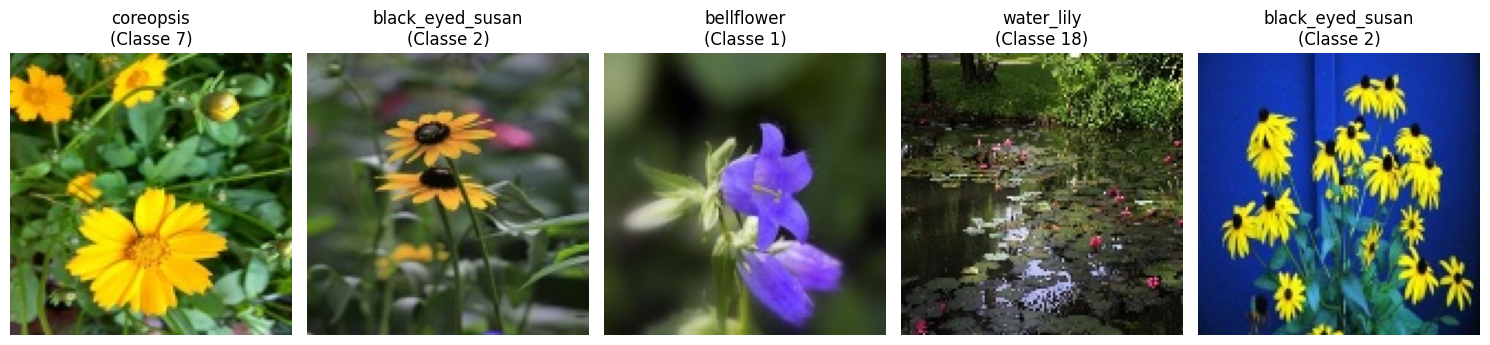

In [ ]:
# --- 1. INFO NUMERICHE ---
print("=== STATISTICHE DATASET TRAIN ===")
print(f"Numero totale immagini: {X_train.shape[0]}")
print(f"Dimensione immagine: {X_train.shape[1]}x{X_train.shape[2]} con {X_train.shape[3]} canali")
print(f"Valore minimo pixel: {X_train.min():.2f}")
print(f"Valore massimo pixel: {X_train.max():.2f}")

print("\n--- Conteggio Classi Train ---")
unique, counts = np.unique(y_train, return_counts=True)
idx_to_class = {v: k for k, v in class_to_idx.items()} # Mappa inversa utile

for label_idx, count in zip(unique, counts):
    nome_classe = idx_to_class[label_idx]
    print(f"Classe {label_idx} ({nome_classe}): {count} immagini")

print("\n--- Conteggio Classi Val ---")
unique_val, counts_val = np.unique(y_val, return_counts=True)
for label_idx, count in zip(unique_val, counts_val):
    nome_classe = idx_to_class[label_idx]
    print(f"Classe {label_idx} ({nome_classe}): {count} immagini")

# --- 2. VISUALIZZAZIONE ESEMPI ---
print("\nESEMPI VISIVI RANDOM")
fig, axes = plt.subplots(1, 5, figsize=(15, 4))

for i in range(5):
    idx_random = np.random.randint(0, len(X_train))
    img = X_train[idx_random]
    label = y_train[idx_random]
    nome_label = idx_to_class[label]

    axes[i].imshow(img)
    axes[i].set_title(f"{nome_label}\n(Classe {label})")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# 1. Configurazione Device
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(" Usando accelerazione Apple MPS (Metal)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print(" Usando accelerazione CUDA (GPU)")
else:
    device = torch.device("cpu")
    print(" MPS e CUDA non trovati, uso CPU")

# 2. Conversione da Numpy a Tensor
# PyTorch vuole (N, Canali, Altezza, Larghezza) -> usiamo permute
# Assicuriamoci che siano float32
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# 3. DataLoader
batch_size = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Dati caricati nei Loader. Batch size: {batch_size}")

 Usando accelerazione CUDA (GPU)
Dati caricati nei Loader. Batch size: 32


In [ ]:
import torch.nn as nn

class OptimizedCNN(nn.Module):
    def __init__(self, num_classes):
        super(OptimizedCNN, self).__init__()

        # --- BLOCCO ESTRAZIONE FEATURES ---
        # Blocco 1
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 128 -> 64
        )

        # Blocco 2
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 64 -> 32
        )

        # Blocco 3
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 32 -> 16
        )

        # Blocco 4
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 16 -> 8
        )

        # --- CLASSIFICATORE ---
        # AdaptiveAvgPool2d((1, 1)) trasforma (Batch, 256, 8, 8) -> (Batch, 256, 1, 1)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        x = self.global_avg_pool(x)
        x = self.classifier(x)
        return x

# Verifica dimensionale rapida
# Calcoliamo dinamicamente il numero di classi dal dizionario creato nel Blocco 1
NUM_CLASSES = len(class_to_idx)
print(f"Configurazione modello per {NUM_CLASSES} classi.")

model = OptimizedCNN(num_classes=NUM_CLASSES)
# Calcolo parametri
params = sum(p.numel() for p in model.parameters())
print(f"Modello creato. Parametri totali: {params:,}")

Configurazione modello per 19 classi.
Modello creato. Parametri totali: 394,259


In [ ]:
import torch.optim as optim

# Configurazione Training
# Ricreiamo il modello e lo spostiamo sul device (GPU/MPS/CPU)
NUM_CLASSES = len(class_to_idx)
model = OptimizedCNN(num_classes=NUM_CLASSES).to(device)

optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=  1e-5)# LR standard
criterion = nn.CrossEntropyLoss()

epochs = 30 # Puoi aumentare se necessario

print(f"Inizio training su device: {device}")

# Liste per salvare lo storico (utile per grafici futuri)
history = {'train_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Barra di progresso
    loop = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", leave=False)

    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Aggiorna la barra
        loop.set_postfix(loss=loss.item())

    # Calcolo accuracy ed epoch loss
    epoch_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_acc = 100 * correct_val / total_val

    # Salvataggio storico
    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    # Stampa finale epoca
    print(f"Epoca {epoch+1:02d} | Loss: {epoch_loss:.4f} | Train: {train_acc:.2f}% | Val: {val_acc:.2f}%")

print("Training completato!")

Inizio training su device: cuda


Epoca 01 | Loss: 2.0472 | Train: 34.77% | Val: 47.56%


Epoca 02 | Loss: 1.6606 | Train: 46.12% | Val: 53.10%


Epoca 03 | Loss: 1.4782 | Train: 52.27% | Val: 59.02%


Epoca 04 | Loss: 1.3752 | Train: 56.24% | Val: 53.44%


Epoca 05 | Loss: 1.2937 | Train: 58.62% | Val: 65.33%


Epoca 06 | Loss: 1.2049 | Train: 61.40% | Val: 53.13%


Epoca 07 | Loss: 1.1598 | Train: 63.15% | Val: 61.84%


Epoca 08 | Loss: 1.1176 | Train: 64.43% | Val: 69.39%


Epoca 09 | Loss: 1.0589 | Train: 66.20% | Val: 70.63%


Epoca 10 | Loss: 1.0130 | Train: 67.52% | Val: 70.43%


Epoca 11 | Loss: 0.9781 | Train: 69.03% | Val: 68.19%


Epoca 12 | Loss: 0.9402 | Train: 69.96% | Val: 63.54%


Epoca 13 | Loss: 0.9159 | Train: 71.04% | Val: 70.82%


Epoca 14 | Loss: 0.8939 | Train: 71.73% | Val: 69.27%


Epoca 15 | Loss: 0.8633 | Train: 72.54% | Val: 71.13%


Epoca 16 | Loss: 0.8281 | Train: 74.05% | Val: 73.37%


Epoca 17 | Loss: 0.8087 | Train: 74.47% | Val: 71.98%


Epoca 18 | Loss: 0.7806 | Train: 74.99% | Val: 74.38%


Epoca 19 | Loss: 0.7489 | Train: 76.08% | Val: 76.24%


Epoca 20 | Loss: 0.7358 | Train: 77.13% | Val: 78.25%


Epoca 21 | Loss: 0.7257 | Train: 76.92% | Val: 75.66%


Epoca 22 | Loss: 0.7065 | Train: 77.59% | Val: 75.81%


Epoca 23 | Loss: 0.6873 | Train: 77.76% | Val: 76.12%


Epoca 24 | Loss: 0.6718 | Train: 79.06% | Val: 78.56%


Epoca 25 | Loss: 0.6512 | Train: 79.30% | Val: 62.31%


Epoca 26 | Loss: 0.6344 | Train: 80.18% | Val: 75.74%


Epoca 27 | Loss: 0.6229 | Train: 79.96% | Val: 77.17%


Epoca 28 | Loss: 0.6087 | Train: 81.04% | Val: 78.29%


Epoca 29 | Loss: 0.5868 | Train: 81.12% | Val: 69.62%


Epoca 30 | Loss: 0.5842 | Train: 81.06% | Val: 78.64%
Training completato!


In [ ]:
print("--- VALUTAZIONE CUSTOM CNN SU TEST SET ---")
model.eval()
correct_test = 0
total_test = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader: # Usa TEST set
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        # Salviamo per eventuale matrice di confusione
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * correct_test / total_test
print(f"Accuracy finale sul Test Set: {test_acc:.2f}%")

--- VALUTAZIONE CUSTOM CNN SU TEST SET ---
Accuracy finale sul Test Set: 78.38%


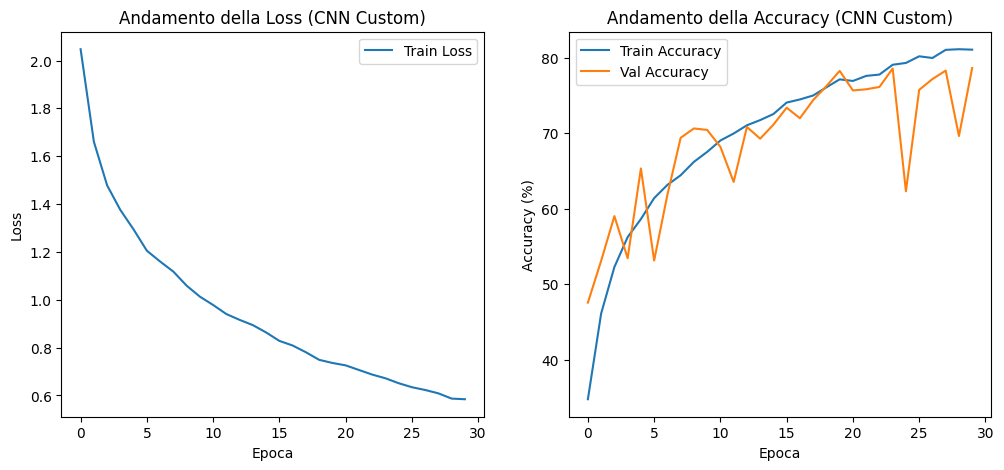

In [ ]:
plt.figure(figsize=(12, 5))

# Grafico Loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.title('Andamento della Loss (CNN Custom)')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.legend()

# Grafico Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy') # Questo è il validation!
plt.title('Andamento della Accuracy (CNN Custom)')
plt.xlabel('Epoca')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [ ]:
# --- CONFIGURAZIONE E TRAINING MOBILENET V2 ---
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

print("=== 1. PREPARAZIONE MOBILENET V2 ===")

# 1. Caricamento pesi pre-addestrati
weights_mb2 = models.MobileNet_V2_Weights.DEFAULT
model_mb2 = models.mobilenet_v2(weights=weights_mb2)

# 2. Freezing (Congeliamo la parte features)
for param in model_mb2.features.parameters():
    param.requires_grad = False

#

# 3. Sostituzione dell'ultimo layer (Testa)
#    In MobileNetV2, 'classifier' è un Sequential con:
#    [0] -> Dropout
#    [1] -> Linear (questo è quello che dobbiamo cambiare)
in_features = model_mb2.classifier[1].in_features
model_mb2.classifier[1] = nn.Linear(in_features, NUM_CLASSES)

# 4. Spostamento su Device
model_mb2 = model_mb2.to(device)

print(f"Modello V2 pronto. Parametri addestrabili: {sum(p.numel() for p in model_mb2.parameters() if p.requires_grad):,}")

# --- CONFIGURAZIONE TRAINING ---
optimizer = optim.Adam(model_mb2.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss()
epochs_transfer = 30

# Liste per storico
history_mb2 = {'train_loss': [], 'train_acc': [], 'val_acc': []}

print(f"\n=== 2. INIZIO TRAINING (MobileNetV2) per {epochs_transfer} epoche ===")

for epoch in range(epochs_transfer):
    model_mb2.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    loop = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs_transfer}", leave=False)

    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_mb2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        loop.set_postfix(loss=loss.item())

    # Statistiche epoca
    epoch_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train

    # Validazione
    model_mb2.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_mb2(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_acc = 100 * correct_val / total_val

    # Salvataggio dati
    history_mb2['train_loss'].append(epoch_loss)
    history_mb2['train_acc'].append(train_acc)
    history_mb2['val_acc'].append(val_acc)

    print(f"Epoca {epoch+1:02d} | Loss: {epoch_loss:.4f} | Train: {train_acc:.2f}% | Val: {val_acc:.2f}%")

print("\nTraining MobileNetV2 completato!")

=== 1. PREPARAZIONE MOBILENET V2 ===
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 100MB/s] 


Modello V2 pronto. Parametri addestrabili: 24,339

=== 2. INIZIO TRAINING (MobileNetV2) per 30 epoche ===


Epoca 01 | Loss: 1.5271 | Train: 64.05% | Val: 78.64%


Epoca 02 | Loss: 0.8975 | Train: 76.43% | Val: 78.64%


Epoca 03 | Loss: 0.7464 | Train: 79.68% | Val: 78.64%


Epoca 04 | Loss: 0.6819 | Train: 80.76% | Val: 78.64%


Epoca 05 | Loss: 0.6354 | Train: 81.76% | Val: 78.64%


Epoca 06 | Loss: 0.5936 | Train: 82.34% | Val: 78.64%


Epoca 07 | Loss: 0.5731 | Train: 83.34% | Val: 78.64%


Epoca 08 | Loss: 0.5429 | Train: 83.71% | Val: 78.64%


Epoca 09 | Loss: 0.5316 | Train: 84.04% | Val: 78.64%


Epoca 10 | Loss: 0.5232 | Train: 84.30% | Val: 78.64%


Epoca 11 | Loss: 0.5094 | Train: 84.34% | Val: 78.64%


Epoca 12 | Loss: 0.4869 | Train: 85.03% | Val: 78.64%


Epoca 13 | Loss: 0.4878 | Train: 84.85% | Val: 78.64%


Epoca 14 | Loss: 0.4653 | Train: 85.97% | Val: 78.64%


Epoca 15 | Loss: 0.4692 | Train: 85.61% | Val: 78.64%


Epoca 16 | Loss: 0.4566 | Train: 85.98% | Val: 78.64%


Epoca 17 | Loss: 0.4549 | Train: 85.95% | Val: 78.64%


Epoca 18 | Loss: 0.4534 | Train: 85.79% | Val: 78.64%


Epoca 19 | Loss: 0.4430 | Train: 85.98% | Val: 78.64%


Epoca 20 | Loss: 0.4458 | Train: 85.94% | Val: 78.64%


Epoca 21 | Loss: 0.4358 | Train: 86.36% | Val: 78.64%


Epoca 22 | Loss: 0.4298 | Train: 86.44% | Val: 78.64%


Epoca 23 | Loss: 0.4228 | Train: 86.49% | Val: 78.64%


Epoca 24 | Loss: 0.4324 | Train: 85.94% | Val: 78.64%


Epoca 25 | Loss: 0.4135 | Train: 86.74% | Val: 78.64%


Epoca 26 | Loss: 0.4170 | Train: 86.65% | Val: 78.64%


Epoca 27 | Loss: 0.4091 | Train: 86.97% | Val: 78.64%


Epoca 28 | Loss: 0.4068 | Train: 86.61% | Val: 78.64%


Epoca 29 | Loss: 0.4083 | Train: 86.71% | Val: 78.64%


Epoca 30 | Loss: 0.4105 | Train: 86.93% | Val: 78.64%

Training MobileNetV2 completato!


In [ ]:
print("--- VALUTAZIONE MOBILENET V2 SU TEST SET ---")
model_mb2.eval()
correct_test = 0
total_test = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader: # Usa TEST set
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_mb2(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        # Salviamo per eventuale matrice di confusione
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * correct_test / total_test
print(f"Accuracy finale MobileNet V2 sul Test Set: {test_acc:.2f}%")

--- VALUTAZIONE MOBILENET V2 SU TEST SET ---
Accuracy finale MobileNet V2 sul Test Set: 81.59%


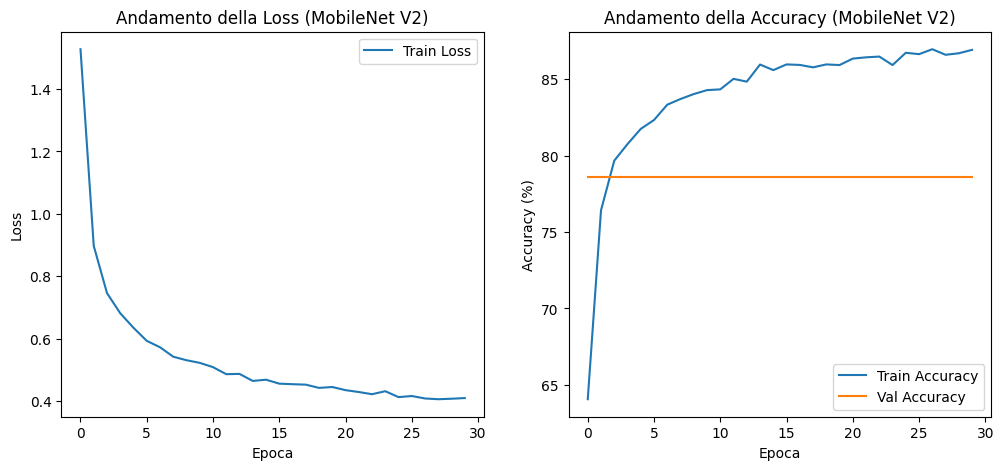

In [ ]:
plt.figure(figsize=(12, 5))

# Grafico Loss
plt.subplot(1, 2, 1)
plt.plot(history_mb2['train_loss'], label='Train Loss')
plt.title('Andamento della Loss (MobileNet V2)')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.legend()

# Grafico Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_mb2['train_acc'], label='Train Accuracy')
plt.plot(history_mb2['val_acc'], label='Val Accuracy') # Questo è il validation!
plt.title('Andamento della Accuracy (MobileNet V2)')
plt.xlabel('Epoca')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()